In [1]:
import sys
sys.path.append('/home/maxim/VisibleSpeech/runtime_speech_recognition/data')
sys.path.append('/home/maxim/VisibleSpeech/runtime_speech_recognition')

In [2]:
sys.path

['/home/maxim/VisibleSpeech/runtime_speech_recognition/notebooks',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/maxim/VisibleSpeech/env/lib/python3.10/site-packages',
 '/home/maxim/VisibleSpeech/runtime_speech_recognition/data',
 '/home/maxim/VisibleSpeech/runtime_speech_recognition']

In [3]:
import torch
from torch import nn

import pytorch_lightning as pl

import torchaudio.transforms as T
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import TIMITDataset, PhonemeLabeler
from utils.utils import set_seed

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
vowel_labels = ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
                'IX', 'AXR', 'AH-H']
consonant_labels = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q', 'M', 'N', 'NG',
                    'EM', 'EN', 'ENG', 'NX', 'JH', 'CH', 'S', 'SH', 'Z', 'ZH',
                    'F', 'TH', 'V', 'DH', 'L', 'R', 'W', 'Y', 'HH', 'HV', 'EL']

phoneme_classes = {
    'vowels': ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
               'IX', 'AXR', 'AH-H'],
    'stops': ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q'],
    'nasals': ['M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX'],
    'affricates': ['JH', 'CH'],
    'fricatives': ['S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'DH'],
    'semivowels_glides': ['L', 'R', 'W', 'Y', 'HH', 'HV', 'EL']
}
phone_labels = vowel_labels + consonant_labels

timit_dataset_train = TIMITDataset(percentage=0.01, usage='train', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                   phone_codes=phone_labels, padding=16000,
                                   description_file_path='../data/timit_description.csv')

timit_dataset_test = TIMITDataset(percentage=0.01, usage='test', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                  phone_codes=phone_labels, padding=16000,
                                  description_file_path='../data/timit_description.csv')

timit_framerate = timit_dataset_train[0].frame_rate

In [5]:
labels = phone_labels
num_of_classes = len(labels)
num_of_classes

52

R


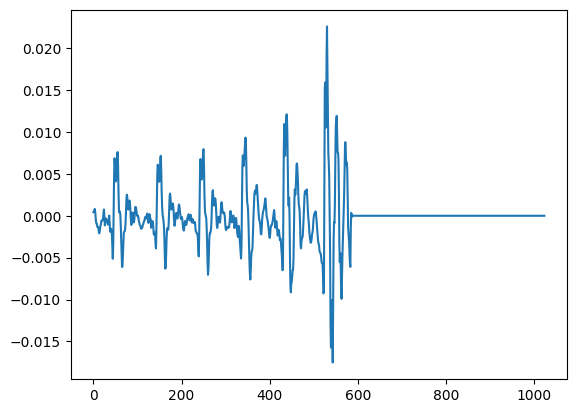

In [6]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)
transform_cpu = T.Resample(orig_freq=timit_framerate, new_freq=8000)

item = 6
timit_waveform = timit_dataset_train[item].data
print(timit_dataset_train[item].label)

chunk_size = 1024

transformed = transform(timit_waveform)[..., :chunk_size]
display(Audio(transformed.numpy(), rate=8000))
plt.plot(transformed.t().numpy());

In [15]:
transformed.shape

torch.Size([1, 1024])

In [19]:
def label_to_index(phone):
    return torch.tensor(labels.index(phone))

# def label_to_index(phone):
#     if phone == 'consonants':
#         return torch.tensor([1, 0])
#     else:
#         return torch.tensor([0, 1])


def index_to_label(index):
    return labels[index]


def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 12
    pin_memory = True
else:
    num_workers = 12
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(transformed.shape[0])

Feature batch shape: torch.Size([256, 1, 16000])
Labels batch shape: torch.Size([256])
1


## Under the hook

In [20]:
transformed.shape

torch.Size([1, 1024])

In [1]:
import torch.nn.functional as F

print(transformed.shape)

kernel_size = 80 # 10
stride = 4 # 2

conv1 = nn.Conv1d(
    in_channels=1,
    out_channels=256,
    kernel_size=kernel_size,
    stride=stride
)
out1 = conv1(transformed)
print(out1.shape)

bn1 = nn.BatchNorm1d(256)
out2 = F.relu(bn1(out1.unsqueeze(0)))
print(out2.shape)

pool1 = nn.MaxPool1d(4)
out2 = pool1(out2)
print(out2.shape)

conv2 = nn.Conv1d(256, 256, kernel_size=3)
bn2 = nn.BatchNorm1d(256)
out3 = conv2(out2)
out3 = F.relu(bn2(out3))
print(out3.shape)

out3= F.avg_pool1d(out2, out2.shape[-1])
print(out3.shape)

fc1 = nn.Linear(256, 2)
sigmoid = nn.Sigmoid()

output = fc1(out3.permute(0, 2, 1))
output = sigmoid(output)
print(output.shape)

IndentationError: unexpected indent (380757000.py, line 5)

torch.Size([256, 508])


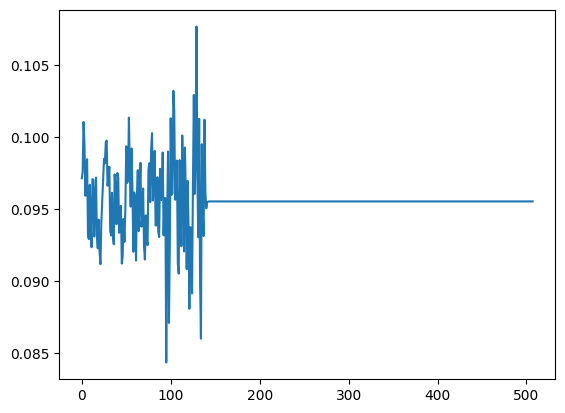

In [29]:


conv1 = nn.Conv1d(
    in_channels=1,
    out_channels=256,
    kernel_size=10,
    stride=2
)

out1 = conv1(transformed)
print(out1.shape)
plt.plot(out1[0].detach().t().numpy())
display(Audio(out1.detach().numpy(), rate=8000))

torch.Size([256, 508])
torch.Size([1, 256, 508])
torch.Size([1, 256, 127])


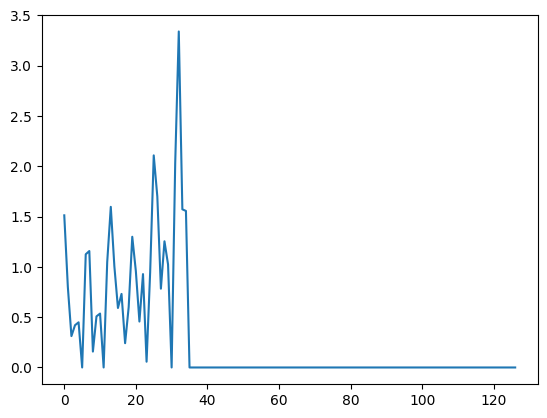

In [30]:
import torch.nn.functional as F
print(out1.shape)

bn1 = nn.BatchNorm1d(256)
out2 = F.relu(bn1(out1.unsqueeze(0)))
print(out2.shape)
pool1 = nn.MaxPool1d(4)
out2 = pool1(out2)

print(out2.shape)
plt.plot(out2[0][0].detach().t().numpy())

torch.Size([1, 256, 57])
torch.Size([1, 256, 57])
torch.Size([1, 256, 57])
torch.Size([1, 256, 14])


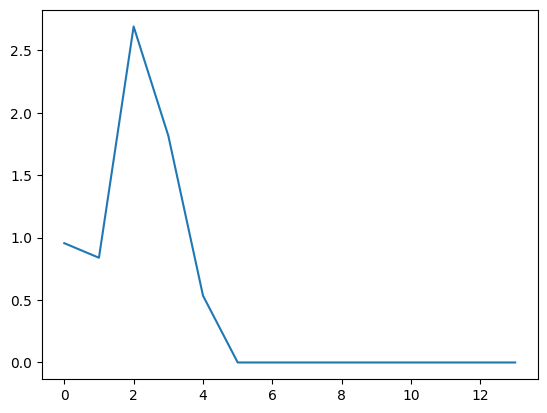

In [23]:
conv2 = nn.Conv1d(
    in_channels=256,
    out_channels=256,
    kernel_size=3
)
bn2 = nn.BatchNorm1d(256)
pool2 = nn.MaxPool1d(4)

out3 = conv2(out2)
print(out3.shape)
out3 = F.relu(bn1(out3))
print(out3.shape)
out2 = pool2(out2)
print(out3.shape)

print(out2.shape)
plt.plot(out2[0][0].detach().t().numpy())

In [44]:
out3.shape, out3.shape[-1]

(torch.Size([1, 256, 493]), 493)

In [45]:
out4 = F.avg_pool1d(out3, out3.shape[-1])
out4.shape

torch.Size([1, 256, 1])

In [46]:
out4 = out4.permute(0, 2, 1)
out4.shape

torch.Size([1, 1, 256])

## Адаптация M11

In [23]:
paper_test = torch.rand(1, 8000)
paper_test.shape

torch.Size([1, 8000])

In [7]:
transformed.shape

torch.Size([1, 1024])

In [8]:
maxpool_kernel = 4

conv1 = nn.Conv1d(
    in_channels=1,
    out_channels=64,
    kernel_size=10,
    stride=2
)

pool1 = nn.MaxPool1d(maxpool_kernel)
out1 = conv1(transformed)
# out1 = bn1(out1)
out1 = pool1(out1)
out1.shape

torch.Size([64, 127])

In [11]:
conv2_block = nn.Sequential(
        nn.Conv1d(
        in_channels=64,
        out_channels=64,
        kernel_size=3,
        stride=1
    ),
    nn.Conv1d(
        in_channels=64,
        out_channels=64,
        kernel_size=3,
        stride=1
    ),
    # nn.Conv1d(
    #     in_channels=64,
    #     out_channels=64,
    #     kernel_size=3,
    #     stride=1
    # ),
)

out2 = conv2_block(out1)
pool2 = nn.MaxPool1d(maxpool_kernel)
out2 = pool2(out2)
out2.shape

torch.Size([64, 30])

In [12]:
conv3_block = nn.Sequential(
        nn.Conv1d(
        in_channels=64,
        out_channels=128,
        kernel_size=3,
        stride=1
    ),
    nn.Conv1d(
        in_channels=128,
        out_channels=128,
        kernel_size=3,
        stride=1
    ),
    # nn.Conv1d(
    #     in_channels=128,
    #     out_channels=128,
    #     kernel_size=3,
    #     stride=1
    # ),
)

out3 = conv3_block(out2)
pool3 = nn.MaxPool1d(maxpool_kernel)
out3 = pool3(out3)
out3.shape

torch.Size([128, 6])

In [16]:
conv4_block = nn.Sequential(
        nn.Conv1d(
        in_channels=128,
        out_channels=256,
        kernel_size=2,
        stride=1
    ),
    nn.Conv1d(
        in_channels=256,
        out_channels=256,
        kernel_size=2,
        stride=1
    ),
    nn.Conv1d(
        in_channels=256,
        out_channels=256,
        kernel_size=2,
        stride=1
    ),
)

out4 = conv4_block(out3)
# pool4 = nn.MaxPool1d(2)
# out4 = pool4(out4)
out4.shape

torch.Size([256, 3])

In [50]:
import torch.nn.functional as F

avg = F.avg_pool1d(out4, out4.shape[-1])
avg.shape

torch.Size([256, 1])